In [1]:
import numpy as np
import pandas as pd
import h5py

%matplotlib inline
import matplotlib.pyplot as plt

import vpfits

from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelextrema

import pymc as mc
from pymc.Matplot import plot
from scipy import stats
from copy import copy
import gc

# Observed Spectrum

Here we test VAMP on a spectrum measured from quasar Q1422+231, at redshift 3.62.

In [2]:
cont = pd.read_table('data/q1422.cont', delim_whitespace=True, header=None)
cont.columns = ['wavelength', 'velocity', 'flux', 'noise']
cont.head()

,wavelength,velocity,flux,noise
0,4744.00,-46840.578,0.045821,0.003992
1,4744.05,-46837.923,0.047369,0.004014
2,4744.10,-46835.241,0.045196,0.003978
3,4744.15,-46832.586,0.037416,0.003850
4,4744.20,-46829.904,0.035414,0.003815


In [3]:
vpfit = vpfits.VPfit()
onesigmaerror = 0.02

## Region Detection

We perform region detection on the entire spectrum, dividing it into regions to be fitted.

In [4]:
min_region_width = 2

taus = -1.*np.log(cont['flux'])

regions, region_pixels = vpfits.compute_detection_regions(cont['wavelength'], taus, cont['flux'], cont['noise'],
                                          min_region_width=min_region_width)

Computing detection regions...
Found 492 detection regions.


In [5]:
region_arrays = []
for region in region_pixels:
    start = region[0]
    end = region[1]
    region_arrays.append([cont['wavelength'].values[start:end], 
                          cont['flux'].values[start:end], 
                          cont['noise'].values[start:end]])

In [6]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

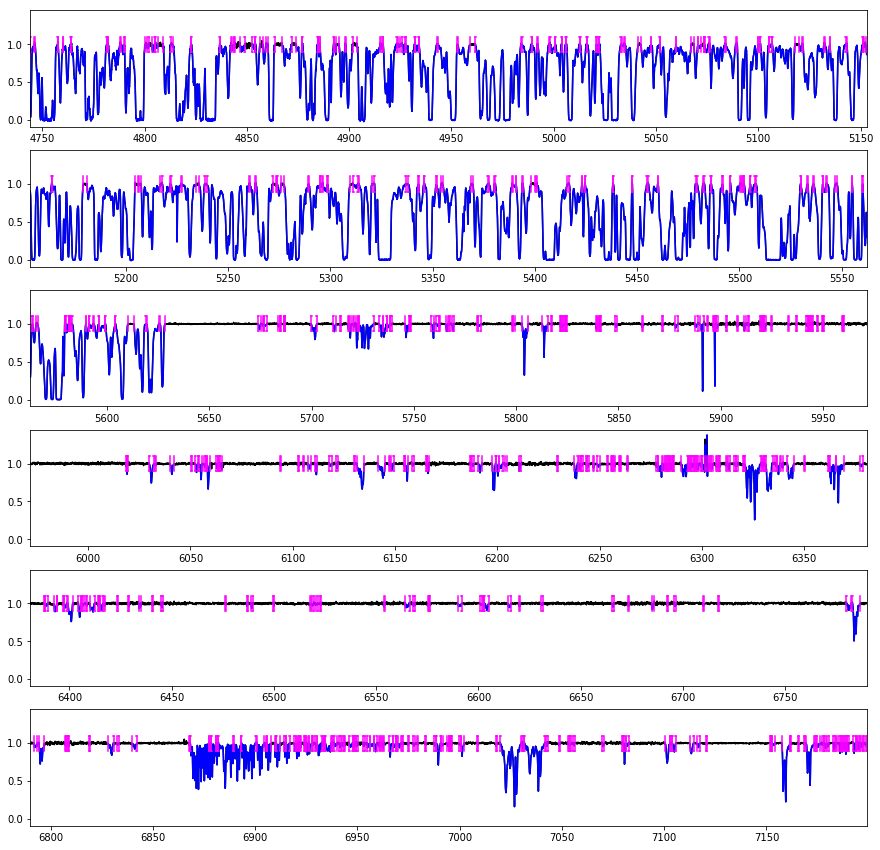

In [8]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(cont) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(cont['wavelength'], cont['flux'], c='black')
    
    ax[n].set_xlim(cont['wavelength'][lower_lim], cont['wavelength'][upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[1], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(cont['wavelength'][start], ax[n], 'left')
        plot_bracket(cont['wavelength'][end], ax[n], 'right')

plt.show()

## Fitting

We fit each region separately, determining the optimal number of profiles to fit with.

Fitting the full spectrum will take a long time - instead fit a short section for the demonstration.

In [ ]:
iterations = 10000
thin = 15
burn = 1000
for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes_orig = region_arrays[i][1]
    fluxes = region_arrays[i][1]
    noise = region_arrays[i][2]
    n = argrelextrema(gaussian_filter(fluxes_orig, 3), np.less)[0].shape[0]
    """Smooth the spectra with a gaussian and find the number of local minima.
    as a safety precaucion, set the initial guess for number of lines to 1 if
    there are less than 4 local minima."""
    if n < 4:
        n = 1
    first = True
    finished = False
    print "Setting initial number of lines to: {}".format(n)
    while not finished:
        bic_array = []
        for j in range(3):
            vpfit_2 = vpfits.VPfit()
            vpfit_2.initialise_model(wavelengths, fluxes, n)
            vpfit_2.map = mc.MAP(vpfit_2.model)
            vpfit_2.mcmc = mc.MCMC(vpfit_2.model)
            vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
            vpfit_2.mcmc.sample(iter=2000, burn=burn, thin=thin, progress_bar=False)
            vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
            vpfit_2.mcmc.sample(iter=2000, burn=burn, thin=thin, progress_bar=False)
            vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
            bic_array.append(vpfit_2.map.BIC)
        if first:
            first = False
            n += 1
            bic_old = vpfit_2.map.BIC
            vpfit_old = copy(vpfit_2)
            del vpfit_2
        else:
            if bic_old > np.average(bic_array):
                print "Old BIC value of {:.2f} is greater than the current {:.2f}.".format(bic_old, np.average(bic_array))
                print "Increasing the number of lines to: {}".format(n+1)
                n += 1
                bic_old = np.average(bic_array)
                vpfit_old = copy(vpfit_2)
                del vpfit_2
            else:
                print "BIC increased with increasing the line number, stopping."
                print "Final n={}.".format(n-1)
                finished = True
    vpfit_old.mcmc.sample(iter=15000, burn=burn, thin=thin, progress_bar=False)
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    vpfit_old.plot(wavelengths, fluxes_orig, n=n-1, start_pix=start, end_pix=end)
    del vpfit_2
    gc.collect()

## Synthetic Spectrum

Here we test VAMP on a synthetic spectrum of a massive central galaxy in the s43 SIMBA simulation, generated using [Pygad](https://bitbucket.org/broett/pygad/src/master/) for the CII 1036 Angstrom line.


In [49]:
data = h5py.File('data/spectrum_pygad_CII1036.h5', 'r')
data.keys()

[u'density_col',
 u'flux',
 u'noise',
 u'tau',
 u'temp',
 u'velocity',
 u'wavelength']

In [50]:
wavelength = data['wavelength'][:]
flux = data['flux'][:]
noise = data['flux'][:]
taus = data['tau'][:]

In [51]:
vpfit = vpfits.VPfit()

In [52]:
regions, region_pixels = vpfits.compute_detection_regions(wavelength, taus, flux, noise,
                                          min_region_width=min_region_width)

Computing detection regions...
Found 4 detection regions.


In [53]:
region_arrays = []
for region in region_pixels:
    start = region[0]
    end = region[1]
    region_arrays.append([wavelength[start:end], taus[start:end], flux[start:end], noise[start:end]])

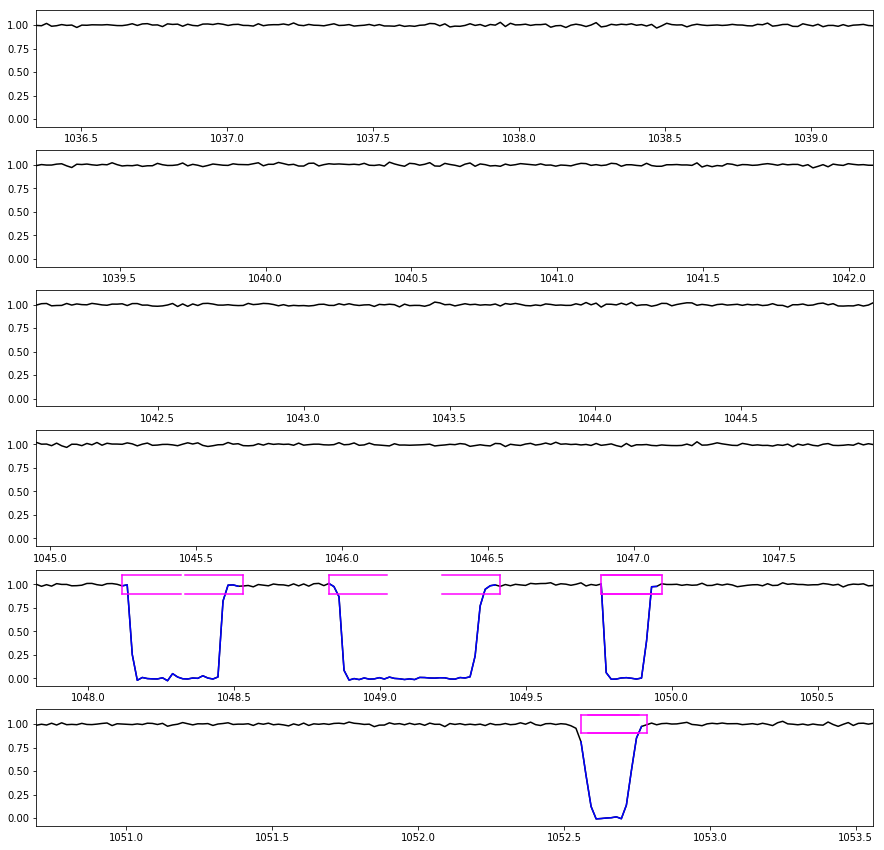

In [63]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(wavelength, flux, c='black')
    
    ax[n].set_xlim(wavelength[lower_lim], wavelength[upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[2], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(wavelength[start], ax[n], 'left')
        plot_bracket(wavelength[end], ax[n], 'right')

plt.show()

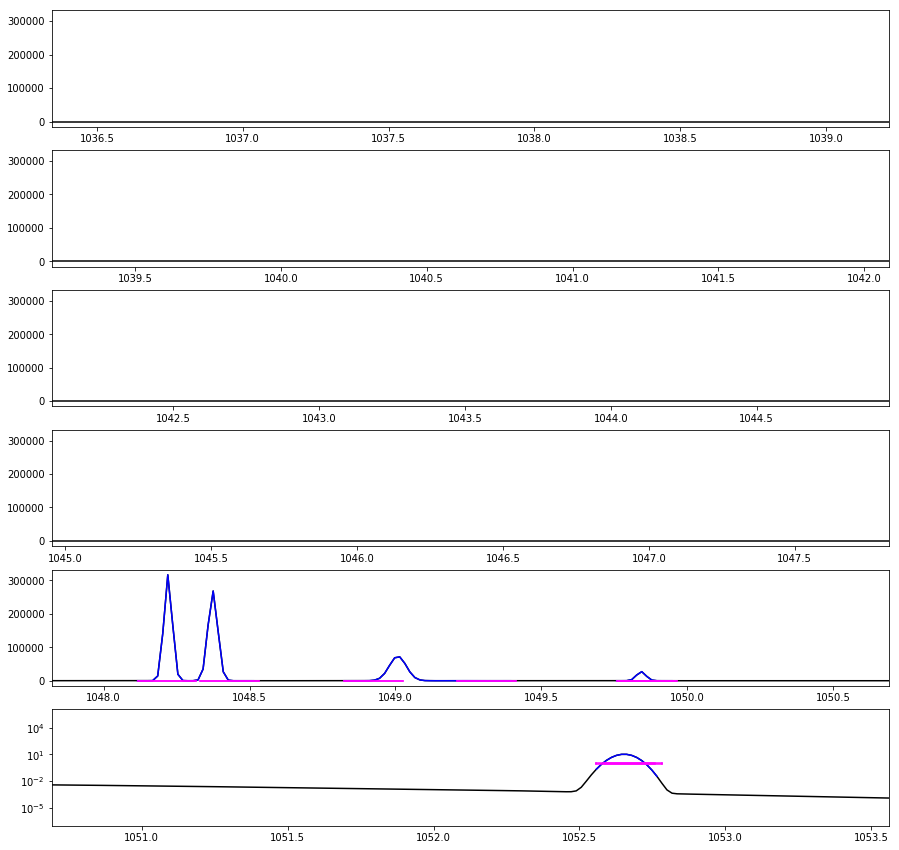

In [66]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))
plt.yscale('log')

length = len(flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(wavelength, taus, c='black')
    
    ax[n].set_xlim(wavelength[lower_lim], wavelength[upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[1], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(wavelength[start], ax[n], 'left')
        plot_bracket(wavelength[end], ax[n], 'right')

plt.show()

## Fitting

We fit each region separately, determining the optimal number of profiles to fit with.

Setting initial number of lines to: 1
Old BIC value of -5.05 is greater than the current -13.77.
Increasing the number of lines to: 3
Old BIC value of -13.77 is greater than the current -73.92.
Increasing the number of lines to: 4
Old BIC value of -73.92 is greater than the current -84.13.
Increasing the number of lines to: 5
Old BIC value of -84.13 is greater than the current -89.82.
Increasing the number of lines to: 6
BIC increased with increasing the line number, stopping.
Final n=5.


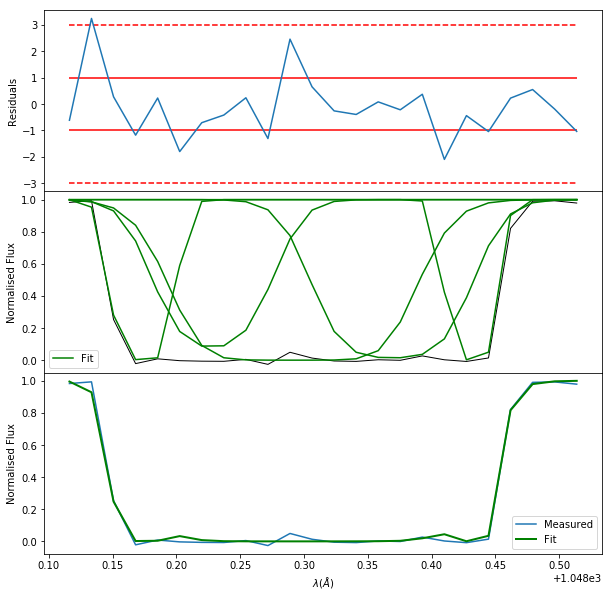

Setting initial number of lines to: 1
Old BIC value of -16.55 is greater than the current -35.26.
Increasing the number of lines to: 3
Old BIC value of -35.26 is greater than the current -161.36.
Increasing the number of lines to: 4
Old BIC value of -161.36 is greater than the current -178.27.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


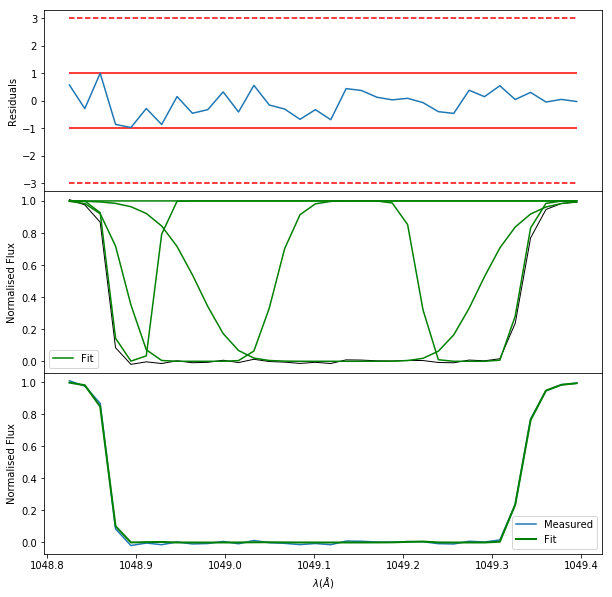

Setting initial number of lines to: 1
Old BIC value of -1.21 is greater than the current -12.13.
Increasing the number of lines to: 3
Old BIC value of -12.13 is greater than the current -39.80.
Increasing the number of lines to: 4
Old BIC value of -39.80 is greater than the current -43.13.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


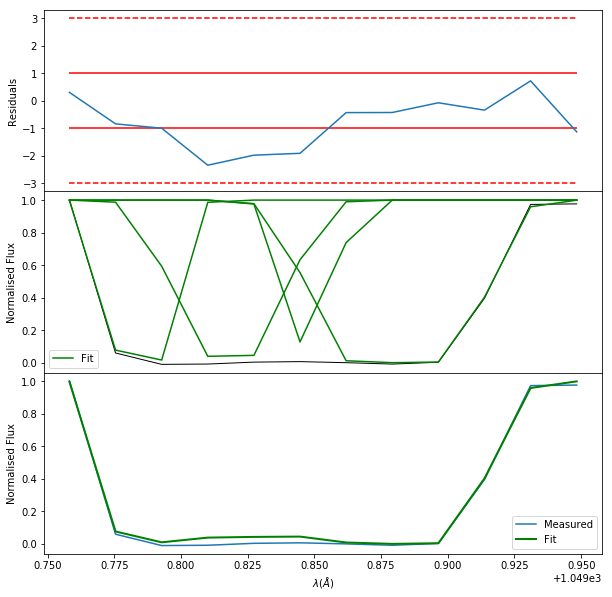

Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


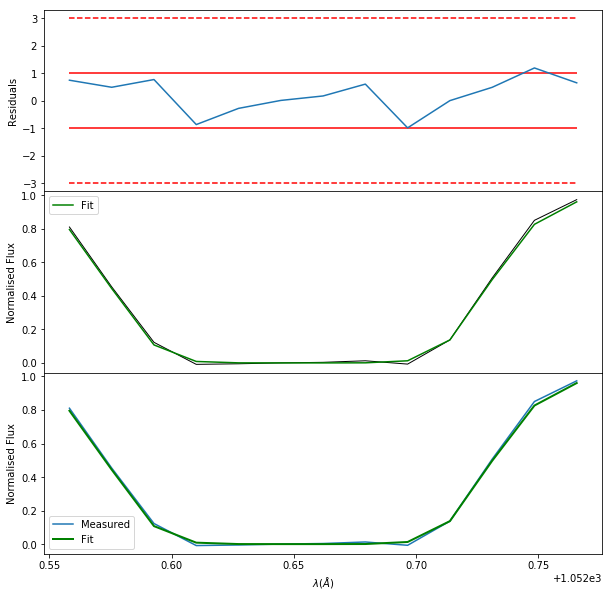

In [67]:
iterations = 10000
thin = 15
burn = 1000
for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes_orig = region_arrays[i][2]
    fluxes = region_arrays[i][2]
    noise = region_arrays[i][3]
    n = argrelextrema(gaussian_filter(fluxes_orig, 3), np.less)[0].shape[0]
    """Smooth the spectra with a gaussian and find the number of local minima.
    as a safety precaucion, set the initial guess for number of lines to 1 if
    there are less than 4 local minima."""
    if n < 4:
        n = 1
    first = True
    finished = False
    print "Setting initial number of lines to: {}".format(n)
    while not finished:
        bic_array = []
        for _ in range(3):
            vpfit_2 = vpfits.VPfit()
            vpfit_2.initialise_model(wavelengths, fluxes, n)
            vpfit_2.map = mc.MAP(vpfit_2.model)
            vpfit_2.mcmc = mc.MCMC(vpfit_2.model)
            vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
            vpfit_2.mcmc.sample(iter=2000, burn=burn, thin=thin, progress_bar=False)
            vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
            vpfit_2.mcmc.sample(iter=2000, burn=burn, thin=thin, progress_bar=False)
            vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
            bic_array.append(vpfit_2.map.BIC)
        if first:
            first = False
            n += 1
            bic_old = vpfit_2.map.BIC
            vpfit_old = copy(vpfit_2)
            del vpfit_2
        else:
            if bic_old > np.average(bic_array):
                print "Old BIC value of {:.2f} is greater than the current {:.2f}.".format(bic_old, np.average(bic_array))
                print "Increasing the number of lines to: {}".format(n+1)
                n += 1
                bic_old = np.average(bic_array)
                vpfit_old = copy(vpfit_2)
                del vpfit_2
            else:
                print "BIC increased with increasing the line number, stopping."
                print "Final n={}.".format(n-1)
                finished = True
    vpfit_old.mcmc.sample(iter=15000, burn=burn, thin=thin, progress_bar=False)
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    vpfit_old.plot(wavelengths, fluxes_orig, n=n-1, start_pix=start, end_pix=end)
    del vpfit_2
    gc.collect()

Now try fitting in optical depth space

In [188]:
l = region_arrays[1][0]
t = region_arrays[1][1]
f = region_arrays[1][2]
ns = region_arrays[1][3]
n = argrelextrema(gaussian_filter(f, 3), np.less)[0].shape[0]

In [196]:
print l[0], l[-1]

1048.8248638958291 1049.395243838476


In [189]:
def GaussFunction(x, amplitude, centroid, sigma):
    """
    Gaussian.
    Args:
        x (numpy array): wavelength array
        amplitude (float)
        centroid (float): must be between the limits of wavelength_array
        sigma (float)
    """
    return amplitude * np.exp(-0.5 * ((x - centroid) / sigma) ** 2)

def Absorption(arr):
    """
    Convert optical depth in to normalised flux profile.
    Args:
        arr (numpy array): array of optical depth values
    """
    return np.exp(-arr)

In [209]:
# initialise Gaussian components

import pymc as mc

estimated_variables = {}
estimated_profiles = []
estimated_variables[0] = {}

@mc.stochastic(name='xexp_%d' % 0)
def xexp(value=0.5):
    if value < 0:
        return -np.inf
    else:
        return np.log(value * np.exp(-value))
        
estimated_variables[0]['height'] = xexp
estimated_variables[0]['centroid'] = mc.Uniform("est_centroid_%d" % 0, l[0], l[-1])
estimated_variables[0]['sigma'] = mc.Uniform("est_sigma_%d" % 0, 0, 5)

@mc.deterministic(name='component_%d' % 0, trace = True)
def init_profile(x=l,
            centroid=estimated_variables[0]['centroid'],
            sigma=estimated_variables[0]['sigma'],
            height=estimated_variables[0]['height']):

    return GaussFunction(x, height, centroid, sigma )

estimated_profiles.append(init_profile)

In [210]:
# initialise model

@mc.deterministic(name='profile', trace=False)
def total(profile_sum=estimated_profiles):
    return sum(profile_sum)


if ns is None:
    std_deviation = 1./(mc.Uniform("sd", 0, 1))**2
else:
    std_deviation = 1./(-1.*np.log(ns))**2

profile = mc.Normal("obs", total, std_deviation, value=t, observed=True)
model = mc.Model([estimated_variables[x][y] for x in estimated_variables for y in estimated_variables[x]])# + [std_deviation])

In [212]:
# MCMC

iterations = 10000
thin = 15
burn = 1000

mapp = mc.MAP(model)
mcmc = mc.MCMC(model)
mapp.fit(iterlim=iterations, tol=1e-3)


RuntimeError: Posterior probability optimization converged to value with zero probability.

In [193]:
print vpfit_old.estimated_variables[0]['centroid'].value
print vpfit_old.estimated_variables[0]['height'].value
print vpfit_old.estimated_variables[0]['sigma'].value



1052.6522053672334
10.156612848985624
0.03410893072619517
